## Ways to Quantify Expressiveness from the Decision Boundary

1.  **Counting Linear (or Affine) Regions**
    *   **What:** For piecewise (affine) models like ReLU networks, the number of distinct linear regions the decision function splits space into.
    *   **Why:** More regions → more "breaks"/"bends" in the boundary → greater expressiveness.
    *   **How:**
        *   Exact counting is computationally hard for large nets, but tractable in low dimension or for small nets.
        *   Reference: Montúfar et al., 2014; Serra et al., 2018.
        *   There are open-source tools that can do this for small networks.
    *   **Use:** Compare two networks—the one with more regions is (all else equal) more expressive.

2.  **Decision Boundary Length (2D) or Surface Area (Higher d)**
    *   **What:** Compute the length of the boundary curve (in 2D) or surface area (in 3D+) separating classes.
    *   **Why:** More expressive models can create longer (more convoluted) boundaries.
    *   **How (practically in 2D):**
        *   Sample a fine grid.
        *   Extract the boundary as a set of points (e.g., by looking where the predicted class changes).
        *   Estimate total curve length by summing segment distances along the curve.
        *   See also Decision Boundary Complexity from Cavalcanti et al., 2018.
    *   **Use:** Compare models numerically—the longer the boundary, the more intricate.

3.  **Curvature Measures**
    *   **What:** How "bendy" is the boundary? High total (integrated) curvature = more turns and complexity.
    *   **How:**
        *   On a grid, approximate the boundary as a collection of points/segments and estimate local curvature.
        *   Integrate (sum) the curvature along the boundary.
    *   **Use:** Especially relevant for networks with smooth nonlinearities, e.g., KAN, tanh, etc.

4.  **Fractal Dimension of the Boundary (for highly expressive models)**
    *   **What:** For very irregular boundaries, the fractal dimension quantifies self-similarity and complexity at many scales.
    *   **How:** Box-counting or related algorithms.
    *   **References:** See, e.g., Fractal dimension of decision boundaries.
    *   **Use:** High fractal dimension = very high expressiveness.

5.  **Empirical Complexity on Synthetic Data**
    *   **What:** Use challenging synthetic benchmarks (moons, spirals, etc.), train your models, and compare the error rate: who can fit the most complicated boundary?
    *   **Why:** Not a geometric measure, but a proxy for expressiveness.

| Method                      | What is Quantified       | Works for ReLU? | Works for KAN? | Relative Difficulty |
|-----------------------------|--------------------------|-----------------|----------------|---------------------|
| Linear regions              | Piecewise regions        | Yes             | Limited        | Med-hard (exact)    |
| Boundary length/surface     | Complexity of boundary  | Yes             | Yes            | Easy                |
| Curvature                   | Bendiness                | Yes             | Yes            | Med                 |
| Fractal dimension           | Self-similarity          | Yes             | Yes            | Hard                |

In [1]:
from kan import KAN
import torch
import torch.nn as nn

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
dtype = torch.get_default_dtype()

In [2]:
# kan_architecture=[2,3,n_classes]
# kan_architecture=[2,3,3,3,3,3,n_classes]

class Args:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

# Dataset Args
n_classes = 2**2
m = 10
n_epochs = 1000
hidden = [2]*5
#hidden = [20]*5
architecture = [2] + hidden + [n_classes]

print(architecture)

args_dict = {
    'seed': 2024,
    #'kan_architecture': [2,n_classes],
    #'kan_architecture': [2,3,n_classes],
    #'kan_architecture': [2,3,3,3,3,3,n_classes],
    #'kan_architecture': [2,3,3,3,3,3,3,3,3,3,3,3,n_classes],
    #'kan_architecture': [2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,n_classes],
    #'kan_architecture': [2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,n_classes],
    'kan_architecture': architecture,
    'grid': 5,
    'k': 3,
    'bounds': (-1,1),
    'learning_rate': 1e-3,
}
args = Args(**args_dict)

[2, 2, 2, 2, 2, 2, 4]


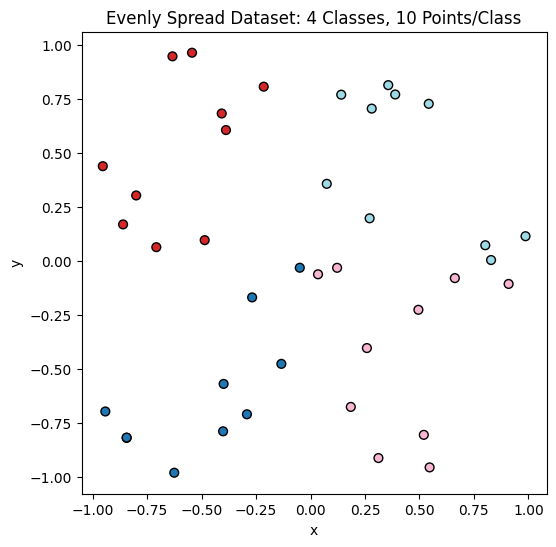

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def create_evenly_spread_dataset(n_classes=32, m=3, bounds=(-1, 1), seed=42):
    np.random.seed(seed)
    # Compute grid size (try to make it as square as possible)
    grid_size = int(np.ceil(np.sqrt(n_classes)))
    x_edges = np.linspace(bounds[0], bounds[1], grid_size + 1)
    y_edges = np.linspace(bounds[0], bounds[1], grid_size + 1)
    data = []
    labels = []
    class_idx = 0
    for i in range(grid_size):
        for j in range(grid_size):
            if class_idx >= n_classes:
                break
            x_min, x_max = x_edges[i], x_edges[i+1]
            y_min, y_max = y_edges[j], y_edges[j+1]
            # Sample m points uniformly within this cell
            xs = np.random.uniform(x_min, x_max, size=(m, 1))
            ys = np.random.uniform(y_min, y_max, size=(m, 1))
            points = np.hstack([xs, ys])
            data.append(points)
            labels.extend([class_idx] * m)
            class_idx += 1
        if class_idx >= n_classes:
            break
    data = np.vstack(data)
    labels = np.array(labels)
    return data, labels


data, labels = create_evenly_spread_dataset(n_classes=n_classes, m=m, bounds=(-1, 1))

plt.figure(figsize=(6, 6))
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab20', edgecolor='k', s=40)
plt.title(f'Evenly Spread Dataset: {n_classes} Classes, {m} Points/Class')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

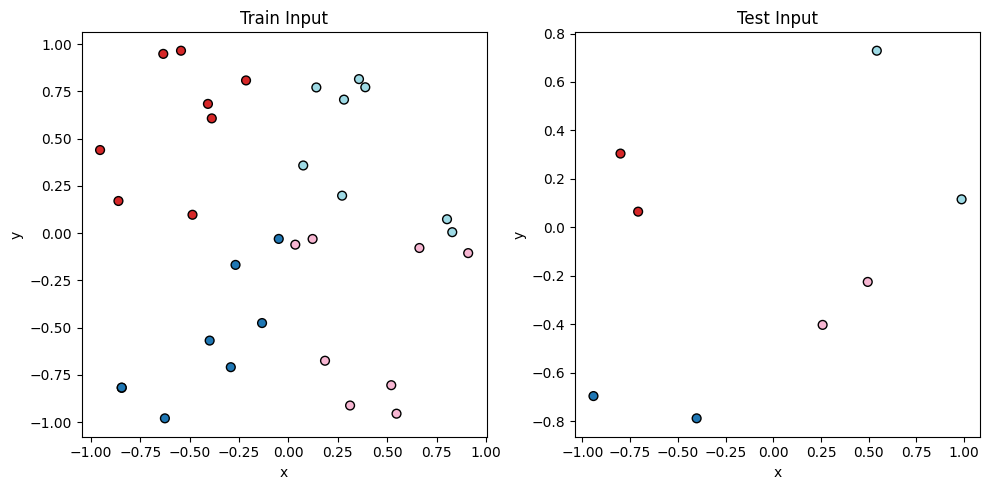

In [4]:
from sklearn.model_selection import train_test_split

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
dtype = torch.get_default_dtype()

# Split data and labels into train/test sets

train_input, test_input, train_label, test_label = train_test_split(
    data, labels, test_size=0.2, random_state=42, stratify=labels
)

dataset = {}
dataset['train_input'] = torch.from_numpy(train_input).type(dtype).to(device)
dataset['test_input'] = torch.from_numpy(test_input).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(train_label).type(torch.long).to(device)
dataset['test_label'] = torch.from_numpy(test_label).type(torch.long).to(device)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot train input
axs[0].scatter(dataset['train_input'][:, 0].cpu(), dataset['train_input'][:, 1].cpu(),
               c=dataset['train_label'].cpu(), cmap='tab20', edgecolor='k', s=40)
axs[0].set_title('Train Input')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

# Plot test input
axs[1].scatter(dataset['test_input'][:, 0].cpu(), dataset['test_input'][:, 1].cpu(),
               c=dataset['test_label'].cpu(), cmap='tab20', edgecolor='k', s=40)
axs[1].set_title('Test Input')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

plt.tight_layout()
plt.show()

In [5]:
def set_kan_linear_spline(kan_model, bound=(-1,1)):
    """
    Set all spline coefficients in a KAN model to linear initialization.
    """
    for layer in kan_model.act_fun:
        if hasattr(layer, 'coef'):
            n_coefs = layer.coef.shape[-1]
            #linear_coefs = torch.linspace(bound[0], bound[1], n_coefs, device=layer.coef.device, dtype=layer.coef.dtype)

            init_bound = torch.sqrt(torch.tensor(2.0) / layer.in_dim)
            #init_bound = torch.sqrt(torch.tensor(6.0) / layer.in_dim)
            linear_coefs = torch.linspace(bound[0]*init_bound, bound[1]*init_bound, n_coefs, device=layer.coef.device, dtype=layer.coef.dtype)

            print(linear_coefs)

            shape = layer.coef.shape
            linear_grid = linear_coefs.expand(*shape[:-1], n_coefs)
            with torch.no_grad():
                layer.coef.copy_(linear_grid)

#set_kan_linear_spline(kan_layerwise)
def set_kan_linear_spline(kan_model, bound=(-1,1)):
    pass

In [6]:
class ReLUMLP(nn.Module):
    def __init__(self, n_hidden=32, n_classes=2, depth=3):
        super().__init__()
        layers = [nn.Linear(2, n_hidden), nn.ReLU()]
        for _ in range(depth - 1):
            layers.append(nn.Linear(n_hidden, n_hidden))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(n_hidden, n_classes))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

mlp = ReLUMLP(n_hidden=16, n_classes=n_classes, depth=3).to(device)
print("MLP")
print(mlp)

# #kan_architecture=[2,3,n_classes]
# kan_architecture=[2,3,3,3,3,3,n_classes]

# class Args:
#     def __init__(self, **kwargs):
#         for key, value in kwargs.items():
#             setattr(self, key, value)

# args_dict = {
#     'seed': 2024,
#     'kan_architecture': [2,3,3,3,3,3,n_classes],
#     'grid': 5,
#     'k': 3,
#     'bounds': (-1,1),
#     'learning_rate': 1e-3,
# }
# args = Args(**args_dict)

kan = KAN(
    width=args.kan_architecture,
    device=device,
    grid=args.grid, k=args.k, #seed=0,
    init_mode='kaiming_in',
    )
print("KAN")
print(kan)



MLP
ReLUMLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=4, bias=True)
  )
)
checkpoint directory created: ./model
saving model version 0.0
KAN
MultKAN(
  (act_fun): ModuleList(
    (0-5): 6 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-5): 6 x Symbolic_KANLayer()
  )
)


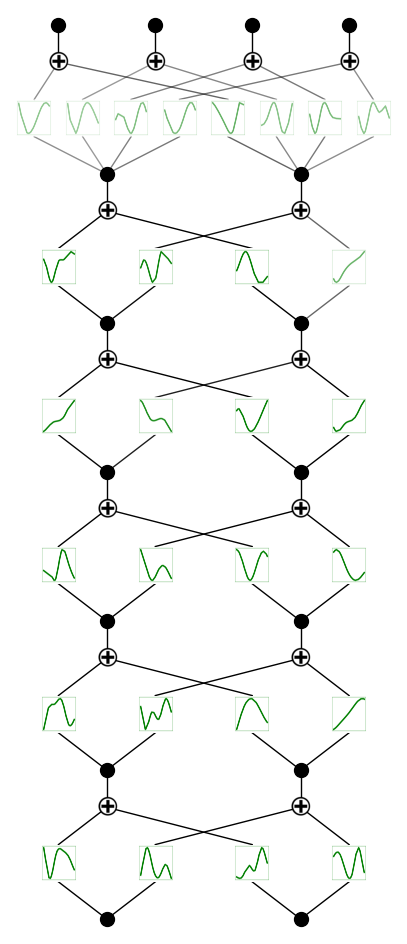

In [7]:
set_kan_linear_spline(kan)
kan(dataset['train_input'])
kan.plot()

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

mlp_param_count = count_parameters(mlp)
kan_param_count = count_parameters(kan)

print(f"MLP parameter count: {mlp_param_count}")
print(f"KAN parameter count: {kan_param_count}")

MLP parameter count: 660
KAN parameter count: 392


# Normal MLP & KAN Training

Epoch 1/1000 | Train Acc: 0.250 | Test Acc: 0.250 | Train Loss: 1.377 | Test Loss: 1.380
Epoch 10/1000 | Train Acc: 0.625 | Test Acc: 0.750 | Train Loss: 1.138 | Test Loss: 1.161
Epoch 20/1000 | Train Acc: 0.844 | Test Acc: 0.875 | Train Loss: 0.752 | Test Loss: 0.730
Epoch 30/1000 | Train Acc: 0.969 | Test Acc: 1.000 | Train Loss: 0.282 | Test Loss: 0.197
Epoch 40/1000 | Train Acc: 1.000 | Test Acc: 1.000 | Train Loss: 0.095 | Test Loss: 0.027
Epoch 50/1000 | Train Acc: 1.000 | Test Acc: 1.000 | Train Loss: 0.043 | Test Loss: 0.003
Epoch 60/1000 | Train Acc: 1.000 | Test Acc: 1.000 | Train Loss: 0.018 | Test Loss: 0.000
Epoch 70/1000 | Train Acc: 1.000 | Test Acc: 1.000 | Train Loss: 0.010 | Test Loss: 0.000
Epoch 80/1000 | Train Acc: 1.000 | Test Acc: 1.000 | Train Loss: 0.006 | Test Loss: 0.000
Epoch 90/1000 | Train Acc: 1.000 | Test Acc: 1.000 | Train Loss: 0.004 | Test Loss: 0.000
Epoch 100/1000 | Train Acc: 1.000 | Test Acc: 1.000 | Train Loss: 0.003 | Test Loss: 0.000
Epoch 110/

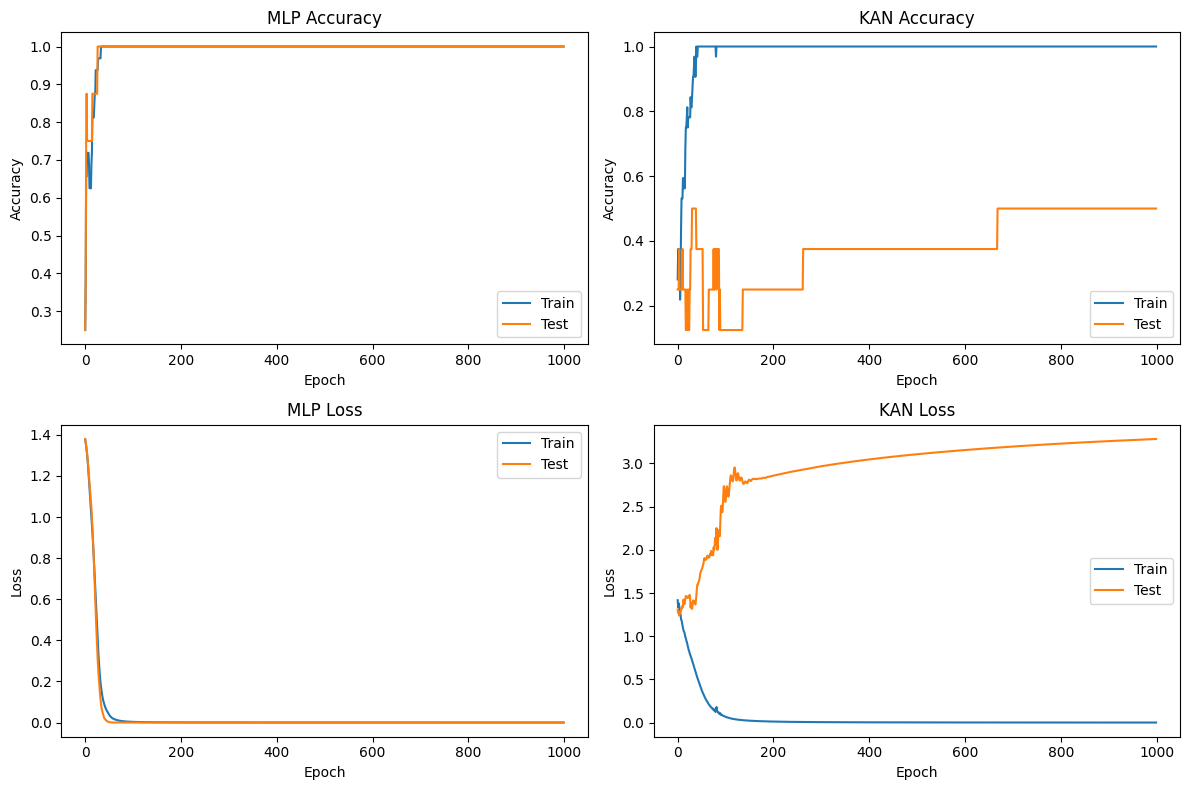

In [9]:
import torch.nn.functional as F

def train_model(model, optimizer, dataset, n_epochs=100, log_interval=10):
    train_input = dataset['train_input']
    train_label = dataset['train_label']
    test_input = dataset['test_input']
    test_label = dataset['test_label']

    train_accs, test_accs, train_losses, test_losses = [], [], [], []

    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(train_input)
        loss = F.cross_entropy(output, train_label)
        loss.backward()
        optimizer.step()

        # Logging
        model.eval()
        with torch.no_grad():
            train_pred = model(train_input).argmax(dim=1)
            test_pred = model(test_input).argmax(dim=1)
            train_acc = (train_pred == train_label).float().mean().item()
            test_acc = (test_pred == test_label).float().mean().item()
            train_loss = F.cross_entropy(model(train_input), train_label).item()
            test_loss = F.cross_entropy(model(test_input), test_label).item()
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
        if (epoch+1) % log_interval == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{n_epochs} | Train Acc: {train_acc:.3f} | Test Acc: {test_acc:.3f} | Train Loss: {train_loss:.3f} | Test Loss: {test_loss:.3f}")

    return {
        'train_accs': train_accs,
        'test_accs': test_accs,
        'train_losses': train_losses,
        'test_losses': test_losses
    }

n_epochs = 1000

# Train MLP
mlp_opt = torch.optim.Adam(mlp.parameters(), lr=1e-2)
mlp_logs = train_model(mlp, mlp_opt, dataset, n_epochs=n_epochs)

# Train KAN
kan_opt = torch.optim.Adam(kan.parameters(), lr=1e-2)
kan_logs = train_model(kan, kan_opt, dataset, n_epochs=n_epochs)

# Plotting
fig, axs_plot = plt.subplots(2, 2, figsize=(12, 8))

# MLP plots
axs_plot[0, 0].plot(mlp_logs['train_accs'], label='Train')
axs_plot[0, 0].plot(mlp_logs['test_accs'], label='Test')
axs_plot[0, 0].set_title('MLP Accuracy')
axs_plot[0, 0].set_xlabel('Epoch')
axs_plot[0, 0].set_ylabel('Accuracy')
axs_plot[0, 0].legend()

axs_plot[1, 0].plot(mlp_logs['train_losses'], label='Train')
axs_plot[1, 0].plot(mlp_logs['test_losses'], label='Test')
axs_plot[1, 0].set_title('MLP Loss')
axs_plot[1, 0].set_xlabel('Epoch')
axs_plot[1, 0].set_ylabel('Loss')
axs_plot[1, 0].legend()

# KAN plots
axs_plot[0, 1].plot(kan_logs['train_accs'], label='Train')
axs_plot[0, 1].plot(kan_logs['test_accs'], label='Test')
axs_plot[0, 1].set_title('KAN Accuracy')
axs_plot[0, 1].set_xlabel('Epoch')
axs_plot[0, 1].set_ylabel('Accuracy')
axs_plot[0, 1].legend()

axs_plot[1, 1].plot(kan_logs['train_losses'], label='Train')
axs_plot[1, 1].plot(kan_logs['test_losses'], label='Test')
axs_plot[1, 1].set_title('KAN Loss')
axs_plot[1, 1].set_xlabel('Epoch')
axs_plot[1, 1].set_ylabel('Loss')
axs_plot[1, 1].legend()

plt.tight_layout()
plt.show()

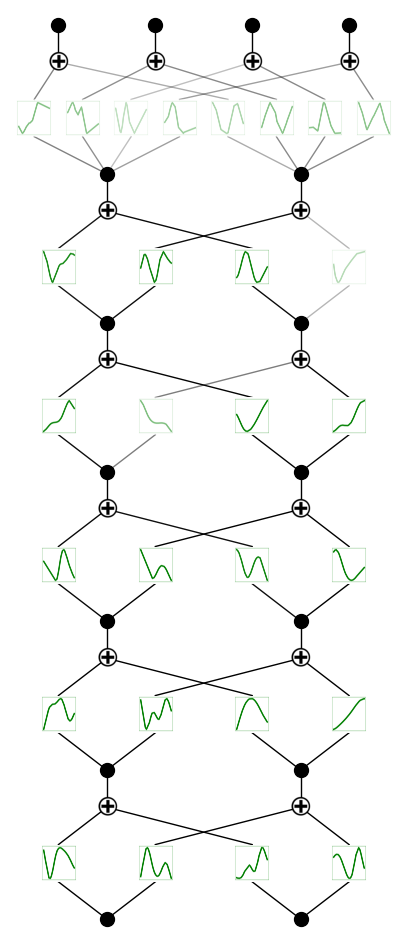

In [10]:
kan(dataset['train_input'])
kan.plot()

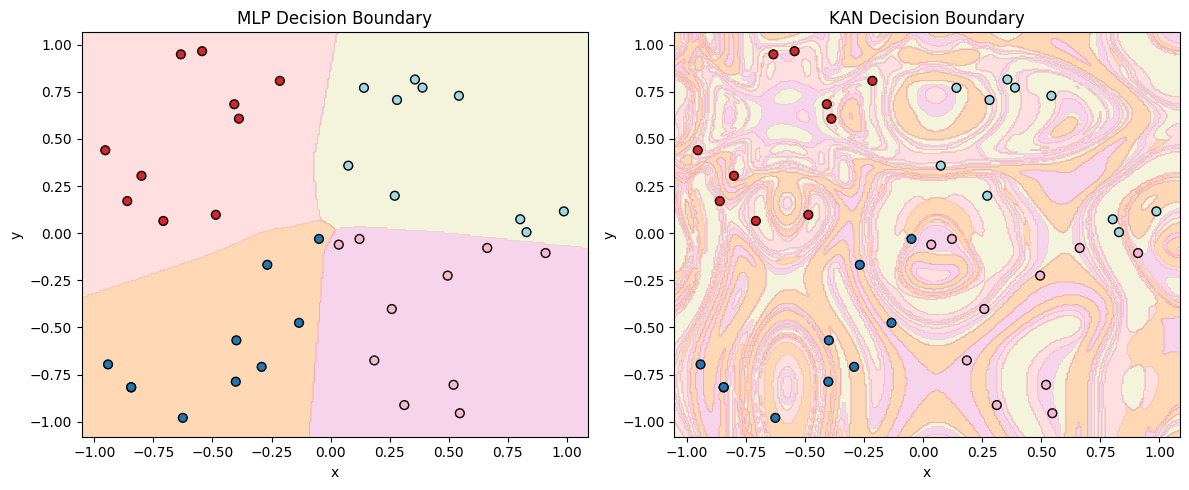

In [11]:
# Create a mesh grid over the input space
xx, yy = np.meshgrid(
    np.linspace(data[:, 0].min() - 0.1, data[:, 0].max() + 0.1, 300),
    np.linspace(data[:, 1].min() - 0.1, data[:, 1].max() + 0.1, 300)
)
grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.from_numpy(grid).type(dtype).to(device)

# Get predictions for each model
mlp.eval()
kan.eval()
with torch.no_grad():
    mlp_pred = mlp(grid_tensor).argmax(dim=1).cpu().numpy().reshape(xx.shape)
    kan_pred = kan(grid_tensor).argmax(dim=1).cpu().numpy().reshape(xx.shape)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot MLP decision boundary
axes[0].contourf(xx, yy, mlp_pred, alpha=0.3, levels=n_classes-1, cmap='tab20')
axes[0].scatter(data[:, 0], data[:, 1], c=labels, cmap='tab20', edgecolor='k', s=40)
axes[0].set_title('MLP Decision Boundary')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')

# Plot KAN decision boundary
axes[1].contourf(xx, yy, kan_pred, alpha=0.3, levels=n_classes-1, cmap='tab20')
axes[1].scatter(data[:, 0], data[:, 1], c=labels, cmap='tab20', edgecolor='k', s=40)
axes[1].set_title('KAN Decision Boundary')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')

plt.tight_layout()
plt.show()

In [12]:
from skimage import measure

# 1. Counting Linear (or Affine) Regions (approximate by counting contiguous regions in prediction map)
def count_linear_regions(pred_map):
    # pred_map: 2D array of predicted class labels
    # Count contiguous regions for each class, sum over all classes
    regions = 0
    for c in np.unique(pred_map):
        labeled = measure.label(pred_map == c, connectivity=1)
        regions += labeled.max()
    return regions

mlp_linear_regions = count_linear_regions(mlp_pred)
kan_linear_regions = count_linear_regions(kan_pred)

# 2. Decision Boundary Length (2D)
def boundary_length(pred_map, xx, yy):
    # Find boundaries between classes
    contours = measure.find_contours(pred_map, 0.5)
    total_length = 0
    for contour in contours:
        # Convert contour indices to x/y coordinates
        x_coords = np.interp(contour[:, 1], np.arange(xx.shape[1]), xx[0])
        y_coords = np.interp(contour[:, 0], np.arange(yy.shape[0]), yy[:, 0])
        points = np.stack([x_coords, y_coords], axis=1)
        seg_lengths = np.linalg.norm(np.diff(points, axis=0), axis=1)
        total_length += seg_lengths.sum()
    return total_length

mlp_boundary_length = boundary_length(mlp_pred, xx, yy)
kan_boundary_length = boundary_length(kan_pred, xx, yy)

# 3. Curvature Measures (approximate: mean absolute angle change along boundary)
def boundary_curvature(pred_map, xx, yy):
    contours = measure.find_contours(pred_map, 0.5)
    total_curvature = 0
    total_points = 0
    for contour in contours:
        x_coords = np.interp(contour[:, 1], np.arange(xx.shape[1]), xx[0])
        y_coords = np.interp(contour[:, 0], np.arange(yy.shape[0]), yy[:, 0])
        points = np.stack([x_coords, y_coords], axis=1)
        if len(points) < 3:
            continue
        v1 = points[1:-1] - points[:-2]
        v2 = points[2:] - points[1:-1]
        # Normalize
        v1 /= np.linalg.norm(v1, axis=1, keepdims=True) + 1e-8
        v2 /= np.linalg.norm(v2, axis=1, keepdims=True) + 1e-8
        dot = np.clip((v1 * v2).sum(axis=1), -1, 1)
        angles = np.arccos(dot)
        total_curvature += np.abs(angles).sum()
        total_points += len(angles)
    mean_curvature = total_curvature / (total_points + 1e-8)
    return mean_curvature

mlp_curvature = boundary_curvature(mlp_pred, xx, yy)
kan_curvature = boundary_curvature(kan_pred, xx, yy)

# 4. Fractal Dimension (Box-counting)
def fractal_dimension(Z):
    # Z: 2D binary image of boundary
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)
        return len(np.where(S > 0)[0])
    # Extract boundary
    boundary = np.zeros_like(Z, dtype=bool)
    for c in np.unique(Z):
        mask = (Z == c)
        eroded = np.zeros_like(mask)
        eroded[1:-1,1:-1] = mask[1:-1,1:-1] & mask[:-2,1:-1] & mask[2:,1:-1] & mask[1:-1,:-2] & mask[1:-1,2:]
        boundary |= mask ^ eroded
    Z = boundary.astype(np.uint8)
    # Minimal dimension of image
    p = min(Z.shape)
    n = 2**np.floor(np.log2(p)).astype(int)
    sizes = 2**np.arange(int(np.log2(n)), 1, -1)
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]

mlp_fractal_dim = fractal_dimension(mlp_pred)
kan_fractal_dim = fractal_dimension(kan_pred)

# Print results
print("MLP:")
print(f"  Linear regions: {mlp_linear_regions}")
print(f"  Boundary length: {mlp_boundary_length:.2f}")
print(f"  Mean curvature: {mlp_curvature:.4f}")
print(f"  Fractal dimension: {mlp_fractal_dim:.4f}")

print("KAN:")
print(f"  Linear regions: {kan_linear_regions}")
print(f"  Boundary length: {kan_boundary_length:.2f}")
print(f"  Mean curvature: {kan_curvature:.4f}")
print(f"  Fractal dimension: {kan_fractal_dim:.4f}")

MLP:
  Linear regions: 4
  Boundary length: 2.40
  Mean curvature: 0.2991
  Fractal dimension: 1.1660
KAN:
  Linear regions: 3415
  Boundary length: 72.36
  Mean curvature: 0.3460
  Fractal dimension: 1.7486


# Train KAN only Layerwise (from last to first)

In [13]:
# def set_kan_linear_spline(kan_model, bound=(-1,1)):
#     """
#     Set all spline coefficients in a KAN model to linear initialization.
#     """
#     for layer in kan_model.act_fun:
#         if hasattr(layer, 'coef'):
#             n_coefs = layer.coef.shape[-1]
#             #linear_coefs = torch.linspace(bound[0], bound[1], n_coefs, device=layer.coef.device, dtype=layer.coef.dtype)

#             init_bound = torch.sqrt(torch.tensor(2.0) / layer.in_dim)
#             #init_bound = torch.sqrt(torch.tensor(6.0) / layer.in_dim)
#             linear_coefs = torch.linspace(bound[0]*init_bound, bound[1]*init_bound, n_coefs, device=layer.coef.device, dtype=layer.coef.dtype)

#             print(linear_coefs)

#             shape = layer.coef.shape
#             linear_grid = linear_coefs.expand(*shape[:-1], n_coefs)
#             with torch.no_grad():
#                 layer.coef.copy_(linear_grid)

# #set_kan_linear_spline(kan_layerwise)


In [14]:
def train_kan_layerwise(kan, optimizer, dataset, n_epochs_per_layer=300, log_interval=20, mode='ascending'):
    """
    Train KAN layer by layer, either in ascending (input to output) or descending (output to input) order.

    Args:
        kan: KAN model
        optimizer: torch optimizer
        dataset: dict with train/test input/label
        n_epochs_per_layer: epochs per layer
        log_interval: print log every this many epochs
        mode: 'ascending' (default) or 'descending'
    """
    # Collect parameter groups for each layer
    param_groups = []
    for idx, (name, param) in enumerate(kan.named_parameters()):
        if 'act_fun' in name or 'symbolic_fun' in name or 'weight' in name or 'bias' in name:
            if '.' in name:
                layer_idx = int(name.split('.')[1])
                while len(param_groups) <= layer_idx:
                    param_groups.append([])
                param_groups[layer_idx].append(param)
    param_groups = [pg for pg in param_groups if len(pg) > 0]

    if mode == 'descending':
        param_groups = param_groups[::-1]

    logs = {'train_accs': [], 'test_accs': [], 'train_losses': [], 'test_losses': []}
    train_input = dataset['train_input']
    train_label = dataset['train_label']
    test_input = dataset['test_input']
    test_label = dataset['test_label']

    for layer_idx, params in enumerate(param_groups):
        for p in kan.parameters():
            p.requires_grad = False
        for p in params:
            p.requires_grad = True

        for epoch in range(n_epochs_per_layer):
            kan.train()
            optimizer.zero_grad()
            output = kan(train_input)
            loss = F.cross_entropy(output, train_label)
            loss.backward()
            optimizer.step()

            kan.eval()
            with torch.no_grad():
                train_pred = kan(train_input).argmax(dim=1)
                test_pred = kan(test_input).argmax(dim=1)
                train_acc = (train_pred == train_label).float().mean().item()
                test_acc = (test_pred == test_label).float().mean().item()
                train_loss = F.cross_entropy(kan(train_input), train_label).item()
                test_loss = F.cross_entropy(kan(test_input), test_label).item()
                logs['train_accs'].append(train_acc)
                logs['test_accs'].append(test_acc)
                logs['train_losses'].append(train_loss)
                logs['test_losses'].append(test_loss)
            if (epoch+1) % log_interval == 0 or epoch == 0:
                print(f"Layer {layer_idx+1}/{len(param_groups)} | Epoch {epoch+1}/{n_epochs_per_layer} | Train Acc: {train_acc:.3f} | Test Acc: {test_acc:.3f} | Train Loss: {train_loss:.3f} | Test Loss: {test_loss:.3f}")

    for p in kan.parameters():
        p.requires_grad = True
    return logs

checkpoint directory created: ./model
saving model version 0.0


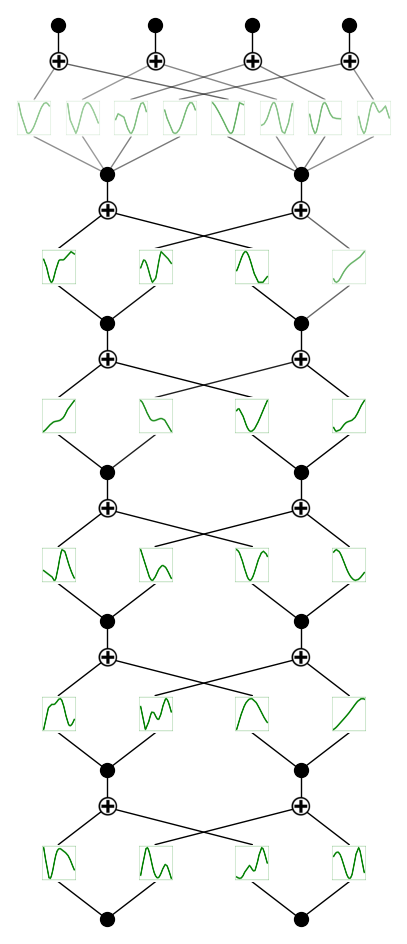

In [15]:
# Re-initialize KAN and optimizer for fair comparison
kan_layerwise = KAN(
    width=args.kan_architecture,
    device=device,
    grid=args.grid, k=args.k,
    init_mode='kaiming_in',
)

set_kan_linear_spline(kan_layerwise)

kan_layerwise(dataset['train_input'])
kan_layerwise.plot()

In [16]:
n_epochs_per_layer = n_epochs // (len(args.kan_architecture)-1)

kan_layerwise.to(device)
kan_layerwise_opt = torch.optim.Adam(kan_layerwise.parameters(), lr=1e-2)
# Train KAN layer by layer
#kan_layerwise_logs = train_kan_layerwise(kan_layerwise, kan_layerwise_opt, dataset, n_epochs_per_layer=500, mode='ascending')
#kan_layerwise_logs = train_kan_layerwise(kan_layerwise, kan_layerwise_opt, dataset, n_epochs_per_layer=500, mode='descending')
kan_layerwise_logs = train_kan_layerwise(kan_layerwise, kan_layerwise_opt, dataset, n_epochs_per_layer=n_epochs_per_layer, mode='descending')

Layer 1/6 | Epoch 1/166 | Train Acc: 0.250 | Test Acc: 0.375 | Train Loss: 1.510 | Test Loss: 1.493
Layer 1/6 | Epoch 20/166 | Train Acc: 0.438 | Test Acc: 0.500 | Train Loss: 1.243 | Test Loss: 1.262
Layer 1/6 | Epoch 40/166 | Train Acc: 0.500 | Test Acc: 0.375 | Train Loss: 1.125 | Test Loss: 1.280
Layer 1/6 | Epoch 60/166 | Train Acc: 0.594 | Test Acc: 0.375 | Train Loss: 1.028 | Test Loss: 1.414
Layer 1/6 | Epoch 80/166 | Train Acc: 0.594 | Test Acc: 0.125 | Train Loss: 0.911 | Test Loss: 1.512
Layer 1/6 | Epoch 100/166 | Train Acc: 0.656 | Test Acc: 0.125 | Train Loss: 0.835 | Test Loss: 1.573
Layer 1/6 | Epoch 120/166 | Train Acc: 0.656 | Test Acc: 0.375 | Train Loss: 0.790 | Test Loss: 1.726
Layer 1/6 | Epoch 140/166 | Train Acc: 0.688 | Test Acc: 0.375 | Train Loss: 0.752 | Test Loss: 1.858
Layer 1/6 | Epoch 160/166 | Train Acc: 0.656 | Test Acc: 0.250 | Train Loss: 0.710 | Test Loss: 2.007
Layer 2/6 | Epoch 1/166 | Train Acc: 0.688 | Test Acc: 0.250 | Train Loss: 0.798 | Test 

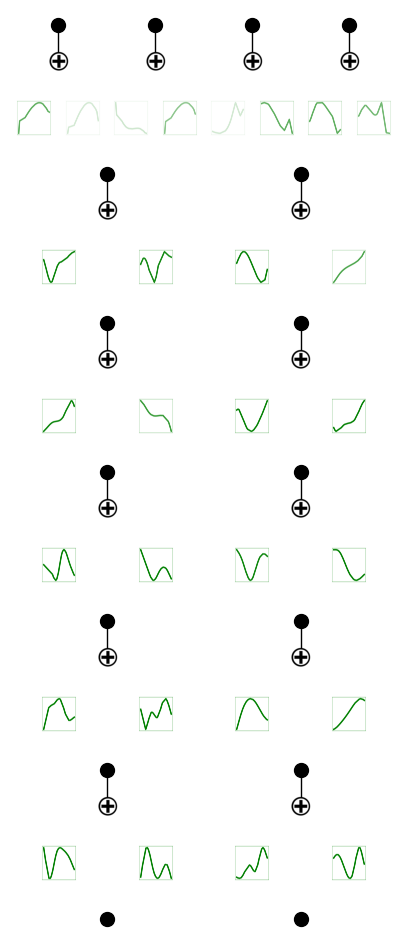

In [17]:
kan_layerwise(dataset['train_input'])
kan_layerwise.plot()

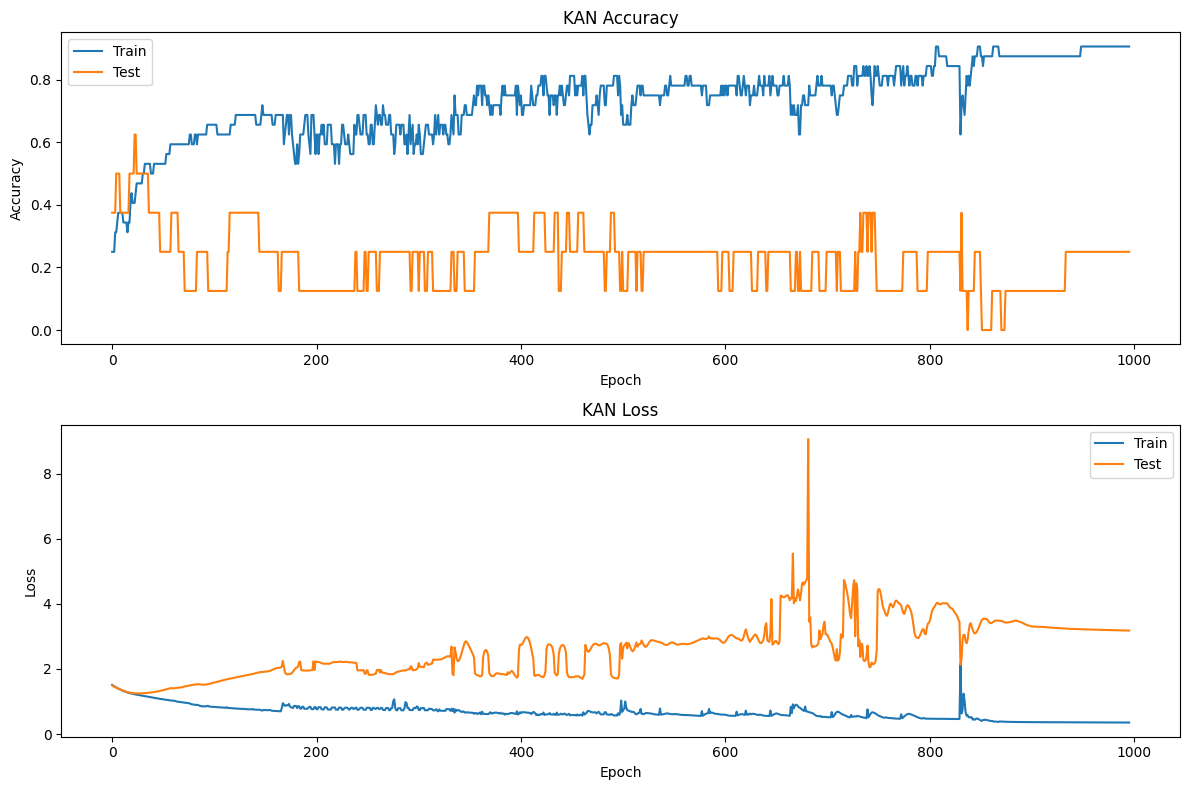

In [18]:
# Plotting
fig, axs_plot = plt.subplots(2, 1, figsize=(12, 8))

# KAN plots
axs_plot[0].plot(kan_layerwise_logs['train_accs'], label='Train')
axs_plot[0].plot(kan_layerwise_logs['test_accs'], label='Test')
axs_plot[0].set_title('KAN Accuracy')
axs_plot[0].set_xlabel('Epoch')
axs_plot[0].set_ylabel('Accuracy')
axs_plot[0].legend()

axs_plot[1].plot(kan_layerwise_logs['train_losses'], label='Train')
axs_plot[1].plot(kan_layerwise_logs['test_losses'], label='Test')
axs_plot[1].set_title('KAN Loss')
axs_plot[1].set_xlabel('Epoch')
axs_plot[1].set_ylabel('Loss')
axs_plot[1].legend()

plt.tight_layout()
plt.show()

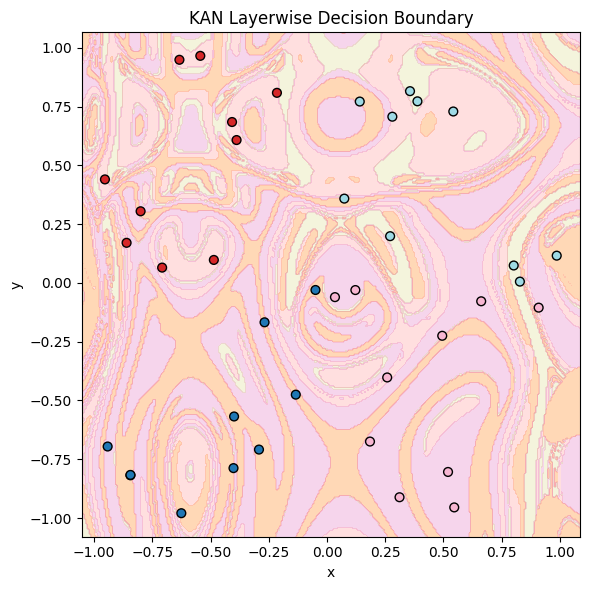

In [19]:
# Evaluate kan_layerwise on the grid
kan_layerwise.eval()
with torch.no_grad():
    kan_layerwise_pred = kan_layerwise(grid_tensor).argmax(dim=1).cpu().numpy().reshape(xx.shape)

plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, kan_layerwise_pred, alpha=0.3, levels=n_classes-1, cmap='tab20')
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab20', edgecolor='k', s=40)
plt.title('KAN Layerwise Decision Boundary')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()

In [20]:
kan_layerwise_linear_regions = count_linear_regions(kan_layerwise_pred)
kan_layerwise_boundary_length = boundary_length(kan_layerwise_pred, xx, yy)
kan_layerwise_curvature = boundary_curvature(kan_layerwise_pred, xx, yy)
kan_layerwise_fractal_dim = fractal_dimension(kan_layerwise_pred)

print("KAN Layerwise:")
print(f"  Linear regions: {kan_layerwise_linear_regions}")
print(f"  Boundary length: {kan_layerwise_boundary_length:.2f}")
print(f"  Mean curvature: {kan_layerwise_curvature:.4f}")
print(f"  Fractal dimension: {kan_layerwise_fractal_dim:.4f}")

KAN Layerwise:
  Linear regions: 2432
  Boundary length: 82.74
  Mean curvature: 0.3513
  Fractal dimension: 1.7290


# Train KAN weighted per layer (higher changes in last layer, less changes in first layer)

checkpoint directory created: ./model
saving model version 0.0


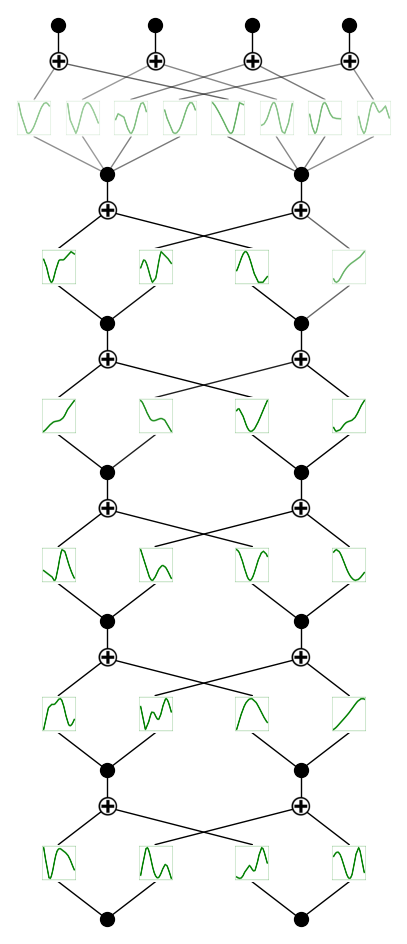

In [21]:
# Re-initialize KAN and optimizer for fair comparison
kan_layerwise_weighted = KAN(
    width=args.kan_architecture,
    device=device,
    grid=args.grid, k=args.k,
    init_mode='kaiming_in',
)

set_kan_linear_spline(kan_layerwise_weighted)

kan_layerwise_weighted(dataset['train_input'])
kan_layerwise_weighted.plot()

In [22]:
kan_layerwise_weighted.to(device)
kan_layerwise_weighted_opt = torch.optim.Adam(kan_layerwise_weighted.parameters(), lr=1e-2)

In [23]:
def fractional_linear_array(n):
    """
    Given an integer n, return an array of n values:
    [1/n, 2/n, ..., (n-1)/n, 1]
    Example: n=4 -> [0.25, 0.5, 0.75, 1.0]
    """
    return [(i + 1) / n for i in range(n)]

print(fractional_linear_array(4))

[0.25, 0.5, 0.75, 1.0]


In [24]:
def fractional_exponential_array(n):
    """
    Given an integer n, return an array of n values that grow exponentially from a small value to 1.
    The first value will be > 0 (not 0.0).
    Example: n=4 -> [exp1, exp2, exp3, 1.0], where exp1 < exp2 < exp3 < 1.0
    """
    base = 2  # You can adjust the base for different growth rates
    exps = np.linspace(0, 1, n+1)
    arr = (base ** exps - 1) / (base - 1)
    return arr[1:].tolist()

print(fractional_exponential_array(4))

[0.18920711500272103, 0.41421356237309515, 0.681792830507429, 1.0]


In [25]:
# Custom optimizer step with per-layer gradient scaling
def weighted_gradient_step(model, optimizer, layer_weights):
    """
    Apply a weighted gradient step to each layer.
    Args:
        model: the KAN model
        optimizer: torch optimizer
        layer_weights: list of floats, one per layer (in order of model.act_fun)
    """
    # Scale gradients for each layer
    for i, layer in enumerate(model.act_fun):
        if hasattr(layer, 'coef'):
            if layer.coef.grad is not None:
                layer.coef.grad.mul_(layer_weights[i])
        if hasattr(layer, 'weight'):
            if layer.weight.grad is not None:
                layer.weight.grad.mul_(layer_weights[i])
        if hasattr(layer, 'bias'):
            if layer.bias.grad is not None:
                layer.bias.grad.mul_(layer_weights[i])
    optimizer.step()

# Training loop with weighted gradients
import torch.nn.functional as F

#n_epochs = 1000
#layer_weights = [0.5, 1.0]  # first layer: 0.5, last layer: 1.0
layer_weights = fractional_linear_array(len(kan_layerwise_weighted.act_fun))
#layer_weights = fractional_exponential_array(len(kan_layerwise_weighted.act_fun))


train_input = dataset['train_input']
train_label = dataset['train_label']
test_input = dataset['test_input']
test_label = dataset['test_label']

train_accs, test_accs, train_losses, test_losses = [], [], [], []

for epoch in range(n_epochs):
    kan_layerwise_weighted.train()
    kan_layerwise_weighted.zero_grad()
    output = kan_layerwise_weighted(train_input)
    loss = F.cross_entropy(output, train_label)
    loss.backward()
    weighted_gradient_step(kan_layerwise_weighted, kan_layerwise_weighted_opt, layer_weights)

    # Logging
    kan_layerwise_weighted.eval()
    with torch.no_grad():
        train_pred = kan_layerwise_weighted(train_input).argmax(dim=1)
        test_pred = kan_layerwise_weighted(test_input).argmax(dim=1)
        train_acc = (train_pred == train_label).float().mean().item()
        test_acc = (test_pred == test_label).float().mean().item()
        train_loss = F.cross_entropy(kan_layerwise_weighted(train_input), train_label).item()
        test_loss = F.cross_entropy(kan_layerwise_weighted(test_input), test_label).item()
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
    if (epoch+1) % 100 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{n_epochs} | Train Acc: {train_acc:.3f} | Test Acc: {test_acc:.3f} | Train Loss: {train_loss:.3f} | Test Loss: {test_loss:.3f}")

kan_layerwise_weighted_logs = {
    'train_accs': train_accs,
    'test_accs': test_accs,
    'train_losses': train_losses,
    'test_losses': test_losses
}

Epoch 1/1000 | Train Acc: 0.281 | Test Acc: 0.250 | Train Loss: 1.417 | Test Loss: 1.306
Epoch 100/1000 | Train Acc: 1.000 | Test Acc: 0.250 | Train Loss: 0.110 | Test Loss: 2.042
Epoch 200/1000 | Train Acc: 1.000 | Test Acc: 0.625 | Train Loss: 0.012 | Test Loss: 1.778
Epoch 300/1000 | Train Acc: 1.000 | Test Acc: 0.750 | Train Loss: 0.005 | Test Loss: 1.803
Epoch 400/1000 | Train Acc: 1.000 | Test Acc: 0.750 | Train Loss: 0.003 | Test Loss: 1.833
Epoch 500/1000 | Train Acc: 1.000 | Test Acc: 0.750 | Train Loss: 0.002 | Test Loss: 1.879
Epoch 600/1000 | Train Acc: 1.000 | Test Acc: 0.750 | Train Loss: 0.001 | Test Loss: 1.974
Epoch 700/1000 | Train Acc: 1.000 | Test Acc: 0.625 | Train Loss: 0.001 | Test Loss: 2.128
Epoch 800/1000 | Train Acc: 1.000 | Test Acc: 0.625 | Train Loss: 0.001 | Test Loss: 2.300
Epoch 900/1000 | Train Acc: 1.000 | Test Acc: 0.625 | Train Loss: 0.001 | Test Loss: 2.460
Epoch 1000/1000 | Train Acc: 1.000 | Test Acc: 0.625 | Train Loss: 0.001 | Test Loss: 2.600


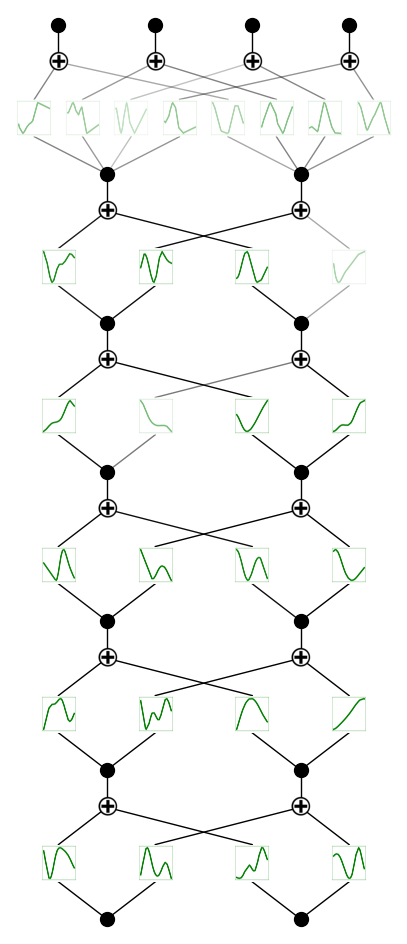

In [26]:
kan_layerwise_weighted(dataset['train_input'])
kan_layerwise_weighted.plot()

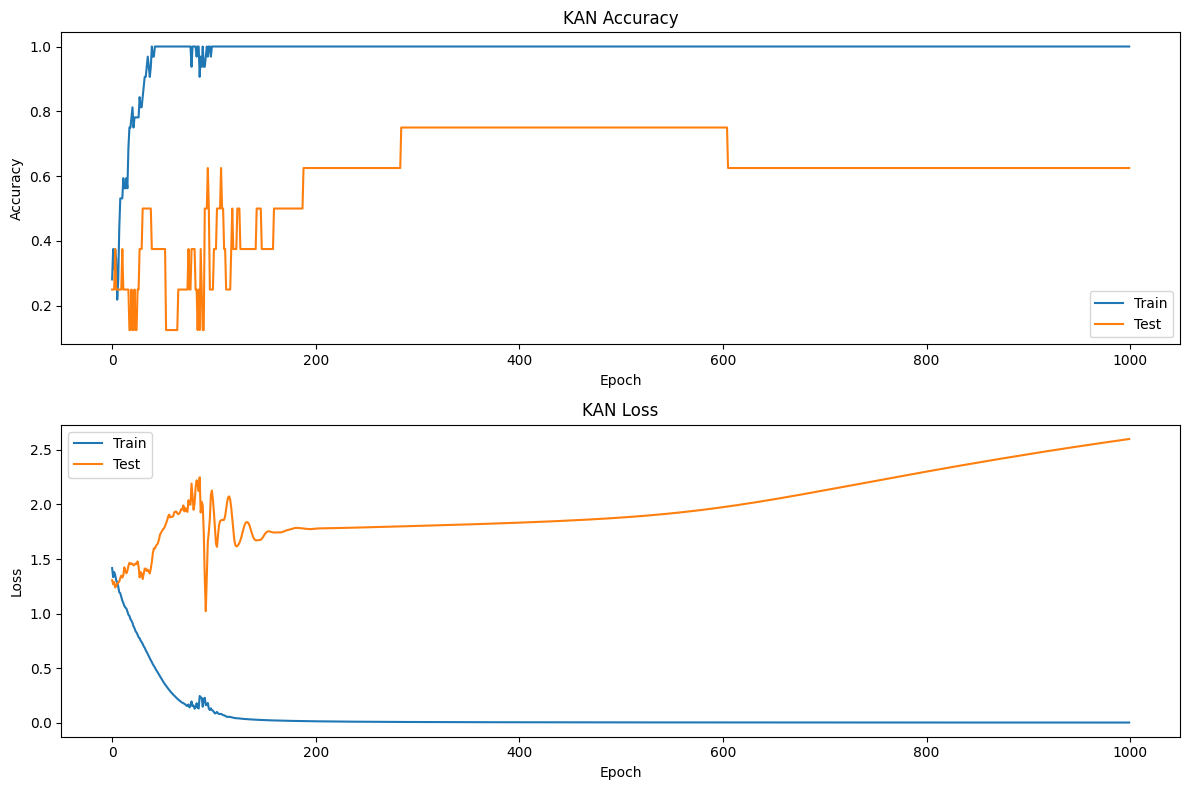

In [27]:

# Plotting
fig, axs_plot = plt.subplots(2, 1, figsize=(12, 8))

# KAN plots
axs_plot[0].plot(kan_layerwise_weighted_logs['train_accs'], label='Train')
axs_plot[0].plot(kan_layerwise_weighted_logs['test_accs'], label='Test')
axs_plot[0].set_title('KAN Accuracy')
axs_plot[0].set_xlabel('Epoch')
axs_plot[0].set_ylabel('Accuracy')
axs_plot[0].legend()

axs_plot[1].plot(kan_layerwise_weighted_logs['train_losses'], label='Train')
axs_plot[1].plot(kan_layerwise_weighted_logs['test_losses'], label='Test')
axs_plot[1].set_title('KAN Loss')
axs_plot[1].set_xlabel('Epoch')
axs_plot[1].set_ylabel('Loss')
axs_plot[1].legend()

plt.tight_layout()
plt.show()

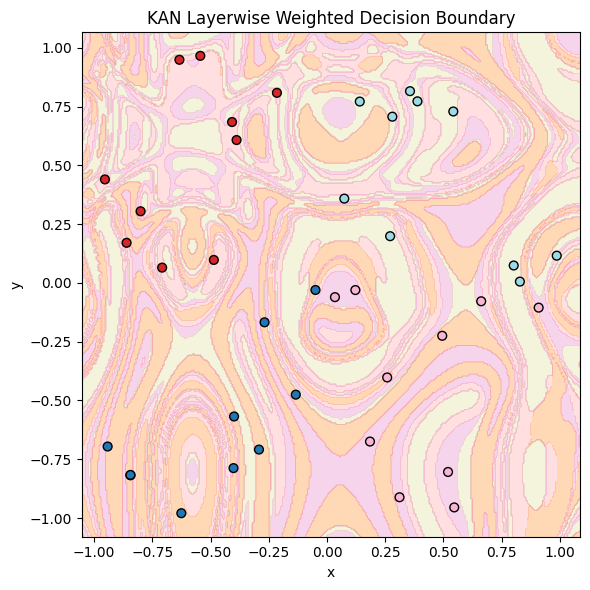

In [28]:
# Evaluate kan_layerwise on the grid
kan_layerwise_weighted.eval()
with torch.no_grad():
    kan_layerwise_weighted_pred = kan_layerwise_weighted(grid_tensor).argmax(dim=1).cpu().numpy().reshape(xx.shape)

plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, kan_layerwise_weighted_pred, alpha=0.3, levels=n_classes-1, cmap='tab20')
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab20', edgecolor='k', s=40)
plt.title('KAN Layerwise Weighted Decision Boundary')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()

In [29]:

kan_layerwise_weighted_linear_regions = count_linear_regions(kan_layerwise_weighted_pred)
kan_layerwise_weighted_boundary_length = boundary_length(kan_layerwise_weighted_pred, xx, yy)
kan_layerwise_weighted_curvature = boundary_curvature(kan_layerwise_weighted_pred, xx, yy)
kan_layerwise_weighted_fractal_dim = fractal_dimension(kan_layerwise_weighted_pred)


print("KAN Layerwise Weighted:")
print(f"  Linear regions: {kan_layerwise_weighted_linear_regions}")
print(f"  Boundary length: {kan_layerwise_weighted_boundary_length:.2f}")
print(f"  Mean curvature: {kan_layerwise_weighted_curvature:.4f}")
print(f"  Fractal dimension: {kan_layerwise_weighted_fractal_dim:.4f}")

KAN Layerwise Weighted:
  Linear regions: 3122
  Boundary length: 79.26
  Mean curvature: 0.3606
  Fractal dimension: 1.7472


# Results

In [30]:
mlp_param_count = count_parameters(mlp)
kan_param_count = count_parameters(kan)

print("mlp_param_count", mlp_param_count)
print("kan_param_count", kan_param_count)

print("MLP Normal:")
print(f"  Train Accuracy: {mlp_logs['train_accs'][-1]:.3f}")
print(f"  Test Accuracy: {mlp_logs['test_accs'][-1]:.3f}")
print(f"  Linear regions: {mlp_linear_regions}")
print(f"  Boundary length: {mlp_boundary_length:.2f}")
print(f"  Mean curvature: {mlp_curvature:.4f}")
print(f"  Fractal dimension: {mlp_fractal_dim:.4f}")

print("KAN Normal:")
print(f"  Train Accuracy: {kan_logs['train_accs'][-1]:.3f}")
print(f"  Test Accuracy: {kan_logs['test_accs'][-1]:.3f}")
print(f"  Linear regions: {kan_linear_regions}")
print(f"  Boundary length: {kan_boundary_length:.2f}")
print(f"  Mean curvature: {kan_curvature:.4f}")
print(f"  Fractal dimension: {kan_fractal_dim:.4f}")

print("KAN Layerwise:")
print(f"  Train Accuracy: {kan_layerwise_logs['train_accs'][-1]:.3f}")
print(f"  Test Accuracy: {kan_layerwise_logs['test_accs'][-1]:.3f}")
print(f"  Linear regions: {kan_layerwise_linear_regions}")
print(f"  Boundary length: {kan_layerwise_boundary_length:.2f}")
print(f"  Mean curvature: {kan_layerwise_curvature:.4f}")
print(f"  Fractal dimension: {kan_layerwise_fractal_dim:.4f}")

print("KAN Layerwise Weighted:")
print(f"  Train Accuracy: {kan_layerwise_weighted_logs['train_accs'][-1]:.3f}")
print(f"  Test Accuracy: {kan_layerwise_weighted_logs['test_accs'][-1]:.3f}")
print(f"  Linear regions: {kan_layerwise_weighted_linear_regions}")
print(f"  Boundary length: {kan_layerwise_weighted_boundary_length:.2f}")
print(f"  Mean curvature: {kan_layerwise_weighted_curvature:.4f}")
print(f"  Fractal dimension: {kan_layerwise_weighted_fractal_dim:.4f}")


mlp_param_count 660
kan_param_count 392
MLP Normal:
  Train Accuracy: 1.000
  Test Accuracy: 1.000
  Linear regions: 4
  Boundary length: 2.40
  Mean curvature: 0.2991
  Fractal dimension: 1.1660
KAN Normal:
  Train Accuracy: 1.000
  Test Accuracy: 0.500
  Linear regions: 3415
  Boundary length: 72.36
  Mean curvature: 0.3460
  Fractal dimension: 1.7486
KAN Layerwise:
  Train Accuracy: 0.906
  Test Accuracy: 0.250
  Linear regions: 2432
  Boundary length: 82.74
  Mean curvature: 0.3513
  Fractal dimension: 1.7290
KAN Layerwise Weighted:
  Train Accuracy: 1.000
  Test Accuracy: 0.625
  Linear regions: 3122
  Boundary length: 79.26
  Mean curvature: 0.3606
  Fractal dimension: 1.7472
